In [3]:
import igraph as ig
import sknetwork as sn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from tqdm import trange, tqdm

from itertools import product
import sys
import os
sys.path.append('../')
from CAS import *

import ecg_sknetwork as ecg_sn
import ecg_igraph as ecg_igraph

from abcd_graph import ABCDGraph, ABCDParams

In [4]:
def community_ecg(self, weights=None, ens_size = 16, min_weight = 0.05, 
                  final='louvain', resolution=1.0, refuse_score=False):
    """
    Stable ensemble-based graph clustering;
    the ensemble consists of single-level randomized Louvain; 
    each member of the ensemble gets a "vote" to determine if the edges 
    are intra-community or not;
    the votes are aggregated into ECG edge-weights in range [0,1]; 
    a final (full depth) Louvain is run using those edge weights;
    
    Parameters
    ----------
    self: graph of type 'igraph.Graph'
      Graph to define the partition on.
    weights: list of double, optional 
      the edge weights
    ens_size: int, optional
      the size of the ensemble of single-level Louvain
    min_weight: double in range [0,1], optional
      the ECG edge weight for edges with zero votes from the ensemble
    final: 'louvain' (default) or 'leiden'
      the algorithm to run on the final re-weighted graph
    resolution: positive float, optional
      resolution parameter; larger values favors smaller communities
      
    Returns
    -------
    partition
      The final partition, of type 'igraph.clustering.VertexClustering'
    partition.W
      The ECG edge weights
    partition.CSI
      The community strength index
    partition.original_modularity
      The modularity with respect to the original edge weights

    Notes
    -----
    The ECG edge weight function is defined as:
      
      min_weight + ( 1 - min_weight ) x (#votes_in_ensemble) / ens_size
      
    Edges outside the 2-core are assigned 'min_weight'.
    
    Examples
    --------
    >>> g = igraph.Graph.Famous('Zachary')
    >>> part = g.community_ecg(ens_size=25, min_weight = .1)
    >>> print(part.CSI)
    
    Reference
    ---------
    Valérie Poulin and François Théberge, "Ensemble clustering for graphs: comparisons and applications", Appl Netw Sci 4, 51 (2019). 
    https://doi.org/10.1007/s41109-019-0162-z
    """
    W = [0]*self.ecount()
    ## Ensemble of level-1 Louvain
    for i in range(ens_size):
        p = np.random.permutation(self.vcount()).tolist()
        g = self.permute_vertices(p)
        l1 = g.community_multilevel(weights=weights, return_levels=True)[0].membership
        b = [l1[p[x.tuple[0]]]==l1[p[x.tuple[1]]] for x in self.es]
        W = [W[i]+b[i] for i in range(len(W))]
    W = [min_weight + (1-min_weight)*W[i]/ens_size for i in range(len(W))]
    ## Force min_weight outside 2-core
    core = self.shell_index()
    ecore = [min(core[x.tuple[0]],core[x.tuple[1]]) for x in self.es]
    w = [W[i] if ecore[i]>1 else min_weight for i in range(len(ecore))]
    if final=='leiden':
        part = self.community_leiden(weights=w, objective_function='modularity', resolution=resolution)
    else:
        part = self.community_multilevel(weights=w, resolution=resolution)
    part.W = W
    part.CSI = 1-2*np.sum([min(1-i,i) for i in W])/len(W)
    part._modularity_params['weights'] = weights
    part.recalculate_modularity()
    
    ## experimental - "refuse to cluster" scores
    if refuse_score:
        self.vs['_deg'] = self.degree()
        self.es['_W'] = part.W
        self.vs['_ecg'] = part.membership
        for v in self.vs:
            scr = 0
            my_comm = v['_ecg']
            good = 0
            bad = 0
            for e in v.incident():
                scr += e['_W']
                if self.vs[e.source]['_ecg'] == self.vs[e.target]['_ecg']:
                    good += e['_W']
                else:
                    bad += e['_W']
            v['_overall'] = ((v['_deg']-scr)/v['_deg'])
            v['_community'] = (bad/(bad+good))        
        part.refuse_overall = self.vs['_overall']
        part.refuse_community = self.vs['_community']
        del(self.vs['_deg'])
        del(self.es['_W'])
        del(self.vs['_ecg'])
        del(self.vs['_overall'])
        del(self.vs['_community'])            
    ## end experimental scores
    
    return part

ig.Graph.community_ecg = community_ecg

## Code to generate ABCD-o graphs

In [5]:
## utility function - we fix all the parameters in the experiments below and only vary xi
def build_ABCD(xi, num_nodes=10000):
    params = ABCDParams(
        vcount=num_nodes, 
        gamma=2.5,
        min_degree=5,
        max_degree=int(num_nodes**.5),
        beta=1.5,
        min_community_size=50,
        max_community_size=int(num_nodes**.767),
        xi=xi,
        num_outliers=0,
    )    
    G = ABCDGraph(params)
    G.build()
    g = G.exporter.to_igraph()
    c = np.array(g.vs['ground_truth_community']) ## outliers have community 0 instead of -1

    return g, c

## Test if CAS scores can weight edges well using ground truth communities

  0%|          | 0/5 [00:00<?, ?it/s]

Got graph
Got is internal


TypeError: not enough arguments: expected 4, got 0

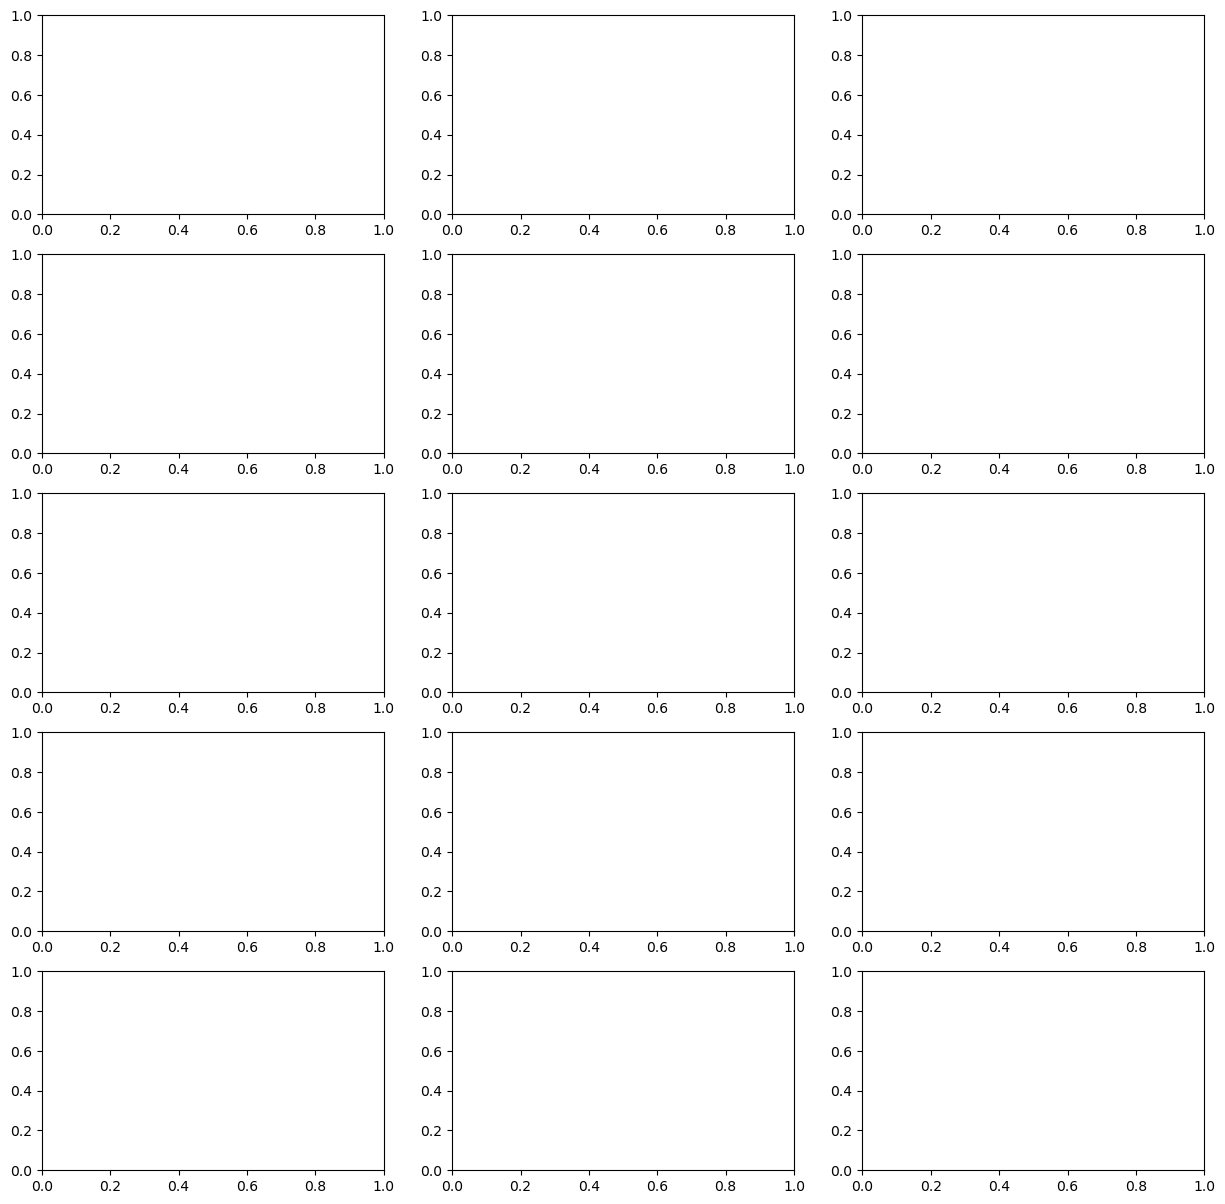

In [6]:
## first with "mid-size" graphs
XIs = [.5, .6, .7, .8, .9]
fig, axs = plt.subplots(len(XIs), 3, figsize=(15, 3*len(XIs)))
for i in trange(len(XIs)):
    xi = XIs[i]
    g, c = build_ABCD(xi)
    print("Got graph")
    is_internal = np.array([c[e.source] == c[e.target] for e in g.es], dtype="bool")
    print("Got is internal")
    weights = ecg_igraph.compute_edge_weights()
    print("Got weights")
    axs[i,0].hist(weights[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 0].hist(weights[is_internal == False], label="External", alpha=0.7)
    axs[i, 0].set_xlabel("Edge Weight")
    axs[i, 0].set_title("IEF")
    axs[i, 0].legend()
    axs[i, 0].set_ylabel(r'$\xi$ ='+str(xi))

    weights = ecg_sn.compute_edge_weights(g.indptr, g.indices, ecg_sn.nief_to_cluster, c)
    axs[i, 1].hist(weights[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 1].hist(weights[is_internal == False], label="External", alpha=0.7)
    axs[i, 1].set_xlabel("Edge Weight")
    axs[i, 1].set_title("NIEF")

    weights = ecg_sn.compute_edge_weights(g.indptr, g.indices, ecg_sn.p_to_cluster, c)
    axs[i, 2].hist(weights[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 2].hist(weights[is_internal == False], label="External", alpha=0.7)
    axs[i, 2].set_xlabel("Edge Weight")
    axs[i, 2].set_title(f"P")


100%|██████████| 9/9 [01:31<00:00, 10.21s/it]


Text(0.5, 0.98, 'CAS-ECG ground truth ROC curves')

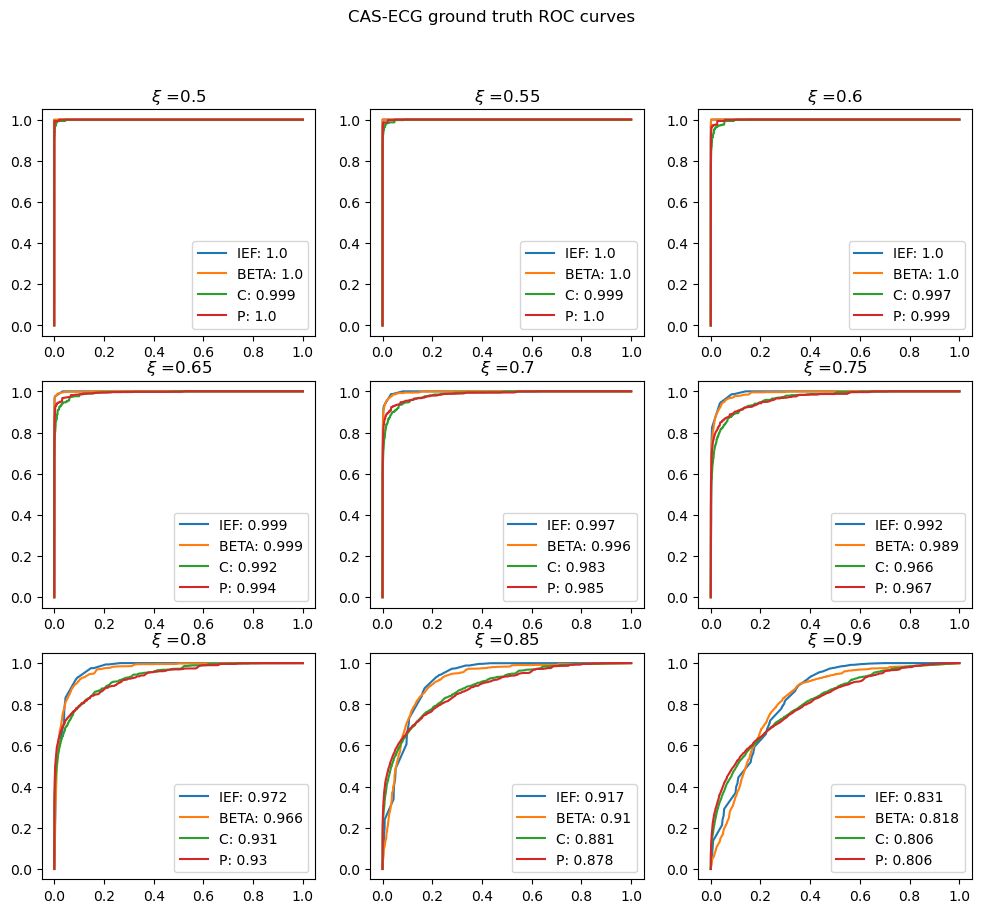

In [9]:
# AUCROC curves for edge weight predicting is-internal
XIs = [.5, .55, .6, .65, .7, .75, .8, .85, .9]
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
for i in trange(len(XIs)):
    xi = XIs[i]
    plt.subplot(3,3,i+1)
    g = build_ABCD(xi)

    gt = np.array(g.vs["gt"])
    ief, beta, c, p, ecg = ecg_igraph.cas_edge_weights(g, gt)
    is_internal = np.array([g.vs[e.source]["gt"] == g.vs[e.target]["gt"] for e in g.es], dtype="bool")

    fpr, tpr, thresholds = roc_curve(is_internal, ief, pos_label=1)
    plt.plot(fpr, tpr, label='IEF: '+str(round(AUC(is_internal, ief),3)))

    fpr, tpr, thresholds = roc_curve(is_internal, beta, pos_label=1)
    plt.plot(fpr, tpr, label='BETA: '+str(round(AUC(is_internal, beta),3)))

    fpr, tpr, thresholds = roc_curve(is_internal, c, pos_label=1)
    plt.plot(fpr, tpr, label='C: '+str(round(AUC(is_internal, c),3)))

    fpr, tpr, thresholds = roc_curve(is_internal, p, pos_label=1)
    plt.plot(fpr, tpr, label='P: '+str(round(AUC(is_internal, p),3)))

    plt.title(r'$\xi$ ='+str(xi))
    plt.legend()
    

plt.suptitle("CAS-ECG ground truth ROC curves")

## Test if the Ensemble edge-weights can perform similarily

100%|██████████| 5/5 [00:37<00:00,  7.60s/it]


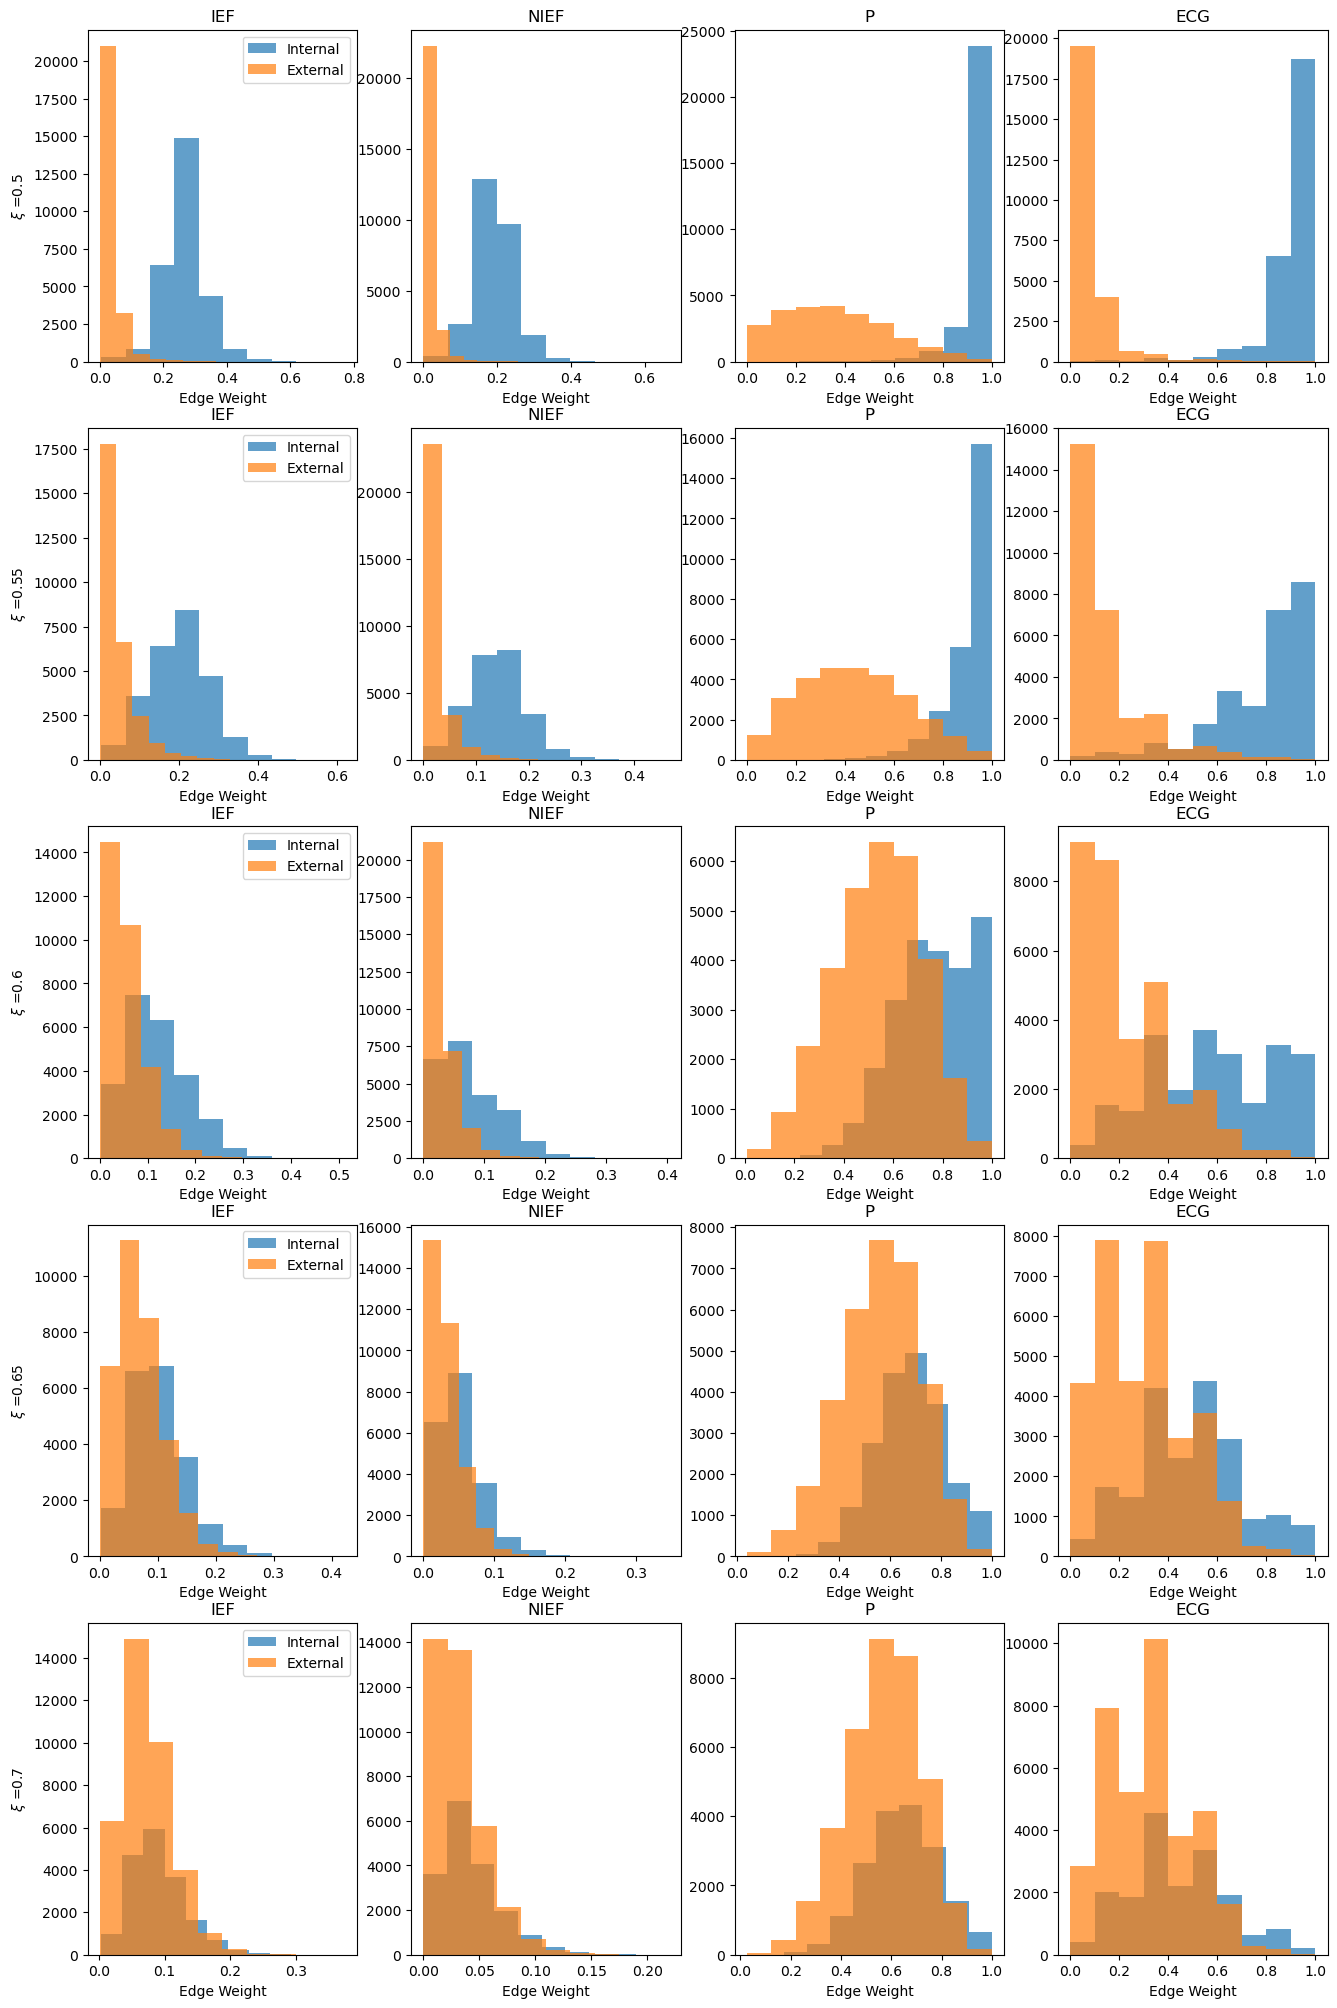

In [6]:
## first with "mid-size" graphs
XIs = [.5, .55, .6, .65, .7]
fig, axs = plt.subplots(len(XIs), 4, figsize=(16, 5*len(XIs)))
for i in trange(len(XIs)):
    xi = XIs[i]
    g, c = build_ABCD(xi)
    is_internal = np.array([c[e.source] == c[e.target] for e in g.es], dtype="bool")

    weights = ecg_igraph.ensemble_edge_weights(g, cas=ecg_igraph.ief_to_cluster)
    axs[i,0].hist(weights[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 0].hist(weights[is_internal == False], label="External", alpha=0.7)
    axs[i, 0].set_xlabel("Edge Weight")
    axs[i, 0].set_title("IEF")
    axs[i, 0].legend()
    axs[i, 0].set_ylabel(r'$\xi$ ='+str(xi))

    weights = ecg_igraph.ensemble_edge_weights(g, cas=ecg_igraph.nief_to_cluster)
    axs[i, 1].hist(weights[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 1].hist(weights[is_internal == False], label="External", alpha=0.7)
    axs[i, 1].set_xlabel("Edge Weight")
    axs[i, 1].set_title("NIEF")

    weights = ecg_igraph.ensemble_edge_weights(g, cas=ecg_igraph.p_to_cluster)
    axs[i, 2].hist(weights[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 2].hist(weights[is_internal == False], label="External", alpha=0.7)
    axs[i, 2].set_xlabel("Edge Weight")
    axs[i, 2].set_title(f"P")

    weights = ecg_igraph.ensemble_edge_weights(g, cas=ecg_igraph.ecg_to_cluster)
    axs[i, 3].hist(weights[is_internal == True], label="Internal", alpha=0.7)
    axs[i, 3].hist(weights[is_internal == False], label="External", alpha=0.7)
    axs[i, 3].set_xlabel("Edge Weight")
    axs[i, 3].set_title(f"ECG")

100%|██████████| 9/9 [01:13<00:00,  8.13s/it]


Text(0.5, 0.98, 'CAS-ECG ground truth ROC curves')

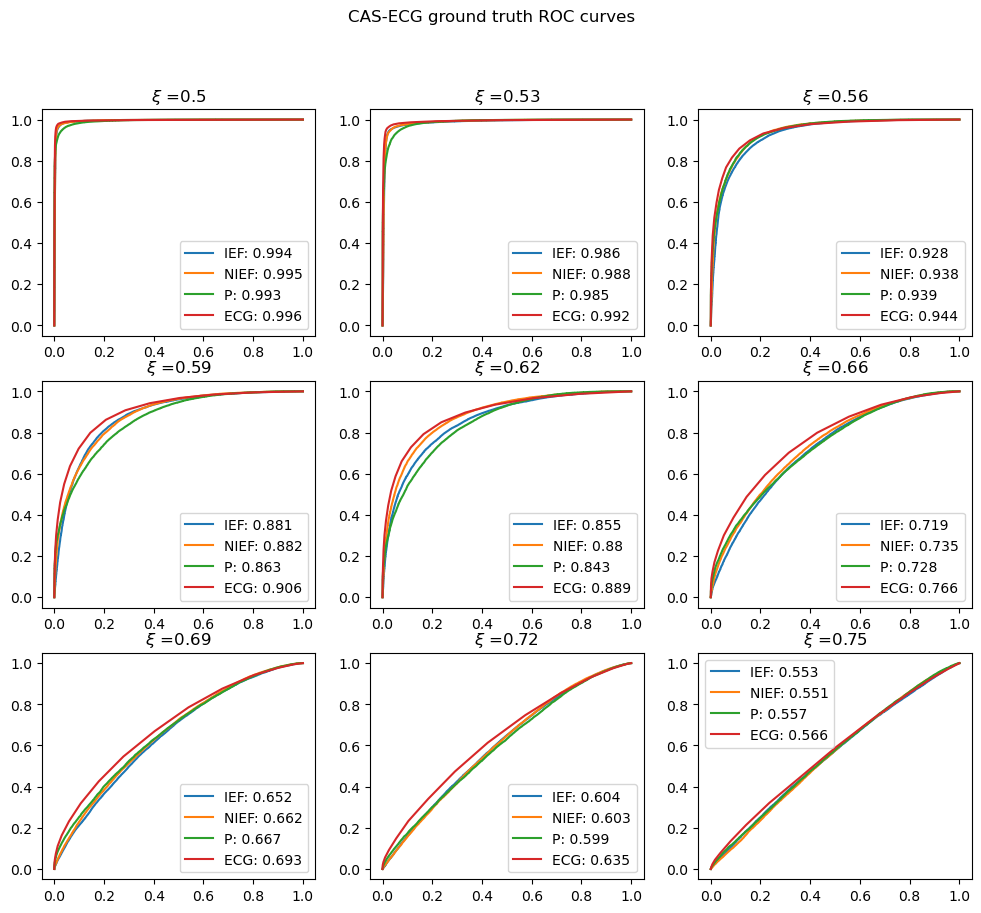

In [9]:
# ROC curves for edge weight predicting is-internal
XIs = np.linspace(.5, .75, 9)
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
for i in trange(len(XIs)):
    xi = XIs[i]
    plt.subplot(3,3,i+1)
    g, c = build_ABCD(xi)
    is_internal = np.array([c[e.source] == c[e.target] for e in g.es], dtype="bool")

    options = [
        ["IEF", ecg_igraph.ief_to_cluster],
        ["NIEF", ecg_igraph.nief_to_cluster],
        ["P", ecg_igraph.p_to_cluster],
        ["ECG", ecg_igraph.ecg_to_cluster]
    ]
    for name, cas in options:
        weights = ecg_igraph.ensemble_edge_weights(g, cas=cas)
        fpr, tpr, thresholds = roc_curve(is_internal, weights, pos_label=1)
        plt.plot(fpr, tpr, label=name+': '+str(round(AUC(is_internal, weights),3)))

    plt.title(r'$\xi$ ='+str(round(xi, 2)))
    plt.legend()
    

plt.suptitle("CAS-ECG ground truth ROC curves")

## A small benchmark for CAS-ECG clustering (CAS WAW Fig 3)

In [7]:
## first with "mid-size" graphs
REP = 50
num_nodes = 10000
num_out = 0

XIs = np.linspace(.4, .7, 25)
data = []
with tqdm(total = len(XIs)*REP) as pbar:
    for xi, rep in product(XIs, range(REP)):
        g, c = build_ABCD(xi)
        data.append(["LEIDEN", xi, rep, AMI(c, g.community_leiden(objective_function="modularity").membership)])  # Leiden baseline
        options = [
            ["IEF AND", ecg_igraph.ief_to_cluster, "and"],
            ["NIEF AND", ecg_igraph.nief_to_cluster, "and"],
            ["P AND", ecg_igraph.p_to_cluster, "and"],
            ["IEF OR", ecg_igraph.ief_to_cluster, "or"],
            ["NIEF OR", ecg_igraph.nief_to_cluster, "or"],
            ["P OR", ecg_igraph.p_to_cluster, "or"],
            ["ECG", ecg_igraph.ecg_to_cluster, "and"]  # combine arg doesn't matter for ECG
        ]
        for name, cas, combine in options:
            weights = ecg_igraph.ensemble_edge_weights(g, cas=cas, combine=combine)
            clustering = ecg_igraph.cluster_edges(g, weights).membership
            data.append([name, xi, rep, AMI(c, clustering)])
        
        # Include reference ecg implementation
        ref_ecg = g.community_ecg(final="leiden").membership
        data.append(["REF ECG", xi, rep, AMI(c, ref_ecg)])

        pbar.update()
pbar.close()

df = pd.DataFrame(data, columns=['name','xi', 'rep', 'score'])
df.to_feather("ecg_benchmark.feather")

100%|██████████| 1250/1250 [4:45:01<00:00, 13.68s/it]  


In [7]:
df = pd.read_feather("ecg_benchmark.feather")

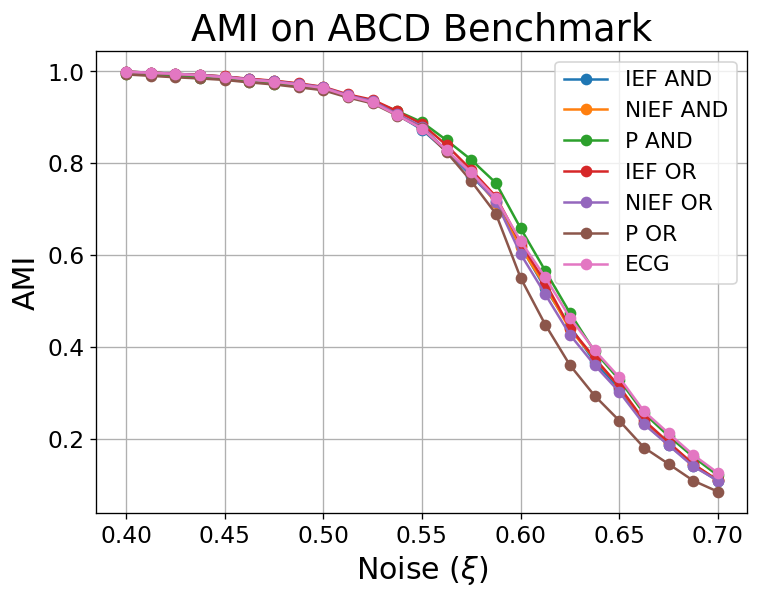

In [31]:
D = df.groupby(['name', "xi"])["score"].mean()

for name in df["name"].unique():
    if name in ["REF ECG", "LEIDEN"]:
        continue
    xis = D[name].index.values
    scores = D[name].values
    plt.plot(xis, scores, 'o-', label=name)
plt.title("AMI on ABCD Benchmark", fontsize=22)
plt.legend(fontsize=13)
plt.grid()
plt.xlabel(r"Noise ($\xi$)", fontsize=18)
plt.ylabel("AMI", fontsize=18)
plt.tick_params(labelsize=14)

fig = plt.gcf()
fig.set_size_inches(7, 5)
fig.set_dpi(120)
fig.savefig("ami-cas-ecg.png", bbox_inches="tight")

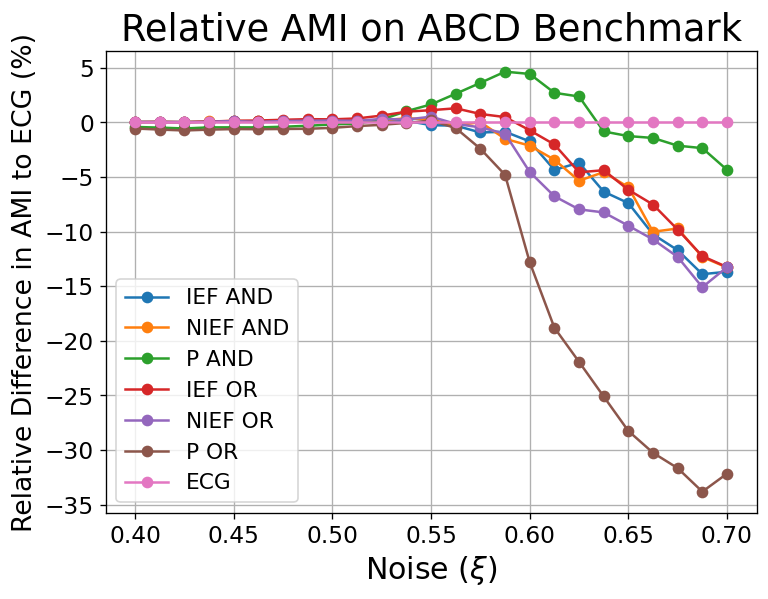

In [32]:
def make_score_array(df, xis, name):
    this_name = df[df['name'] == name]
    xis = df['xi'].unique()
    reps = df['rep'].unique()
    scores = np.empty((len(xis), len(reps)), dtype='float64')
    for i, xi in enumerate(xis):
        for j in reps:
            scores[i, j] = this_name.loc[(this_name['rep'] == j) & (this_name['xi'] == xi)].score.values[0]
    return scores


xis = df['xi'].unique()
baseline = make_score_array(df, xis, "ECG")
for name in df["name"].unique():
    if name in ["REF ECG", "LEIDEN"]:
        continue
    scores = make_score_array(df, xis, name)
    mean_diff = (np.mean((scores - baseline)/baseline, axis=1)) * 100
    plt.plot(xis, mean_diff, 'o-', label=name)
plt.title("Relative AMI on ABCD Benchmark", fontsize=22)
plt.legend(fontsize=13)
plt.grid()
#plt.ylim((-0.35, 0.07))
plt.xlabel(r"Noise ($\xi$)", fontsize=18)
plt.ylabel("Relative Difference in AMI to ECG (%)", fontsize=16)
plt.tick_params(labelsize=14)

fig = plt.gcf()
fig.set_size_inches(7, 5)
fig.set_dpi(120)
fig.savefig("relative-ami-cas-ecg.png", bbox_inches="tight")

## Ideas

Hypothesis testing that P-AND is better than ECG.
For any particular set of parameters the AMI's look normally(ish) distrubuted.
1. P-Value that mean P-AND > mean ECG
2. Largest difference such that p=0.05 (is there a type of hypothesis test for this? used in literature?)

## Real world graphs with known communities

In [20]:
%%time
g = ig.Graph.Read_GML("real_data/football.gml")
g = g.as_undirected()
vals = np.unique(g.vs["gt"])
id_map = {j:i for i,j in enumerate(vals)}
gt = np.array([id_map[i] for i in g.vs["gt"]])

CPU times: user 2.42 ms, sys: 0 ns, total: 2.42 ms
Wall time: 2.33 ms


<timed exec>:1: RuntimeWarning: Unterminated entity or stray & character found, will be returned verbatim. at src/io/gml.c:148


In [21]:
w = ecg_igraph.ensemble_edge_weights(g, cas=ecg_igraph.ief_to_cluster)
c = ecg_igraph.cluster_edges(g, w).membership
print(f"IEF AMI {AMI(gt, c)}")

w = ecg_igraph.ensemble_edge_weights(g, cas=ecg_igraph.nief_to_cluster)
c = ecg_igraph.cluster_edges(g, w).membership
print(f"NIEF AMI {AMI(gt, c)}")

w = ecg_igraph.ensemble_edge_weights(g, cas=ecg_igraph.p_to_cluster)
c = ecg_igraph.cluster_edges(g, w).membership
print(f"P AMI {AMI(gt, c)}")

w = ecg_igraph.ensemble_edge_weights(g, cas=ecg_igraph.ecg_to_cluster)
c = ecg_igraph.cluster_edges(g, w).membership
print(f"ECG AMI {AMI(gt, c)}")

IEF AMI 0.88443255023394
NIEF AMI 0.88443255023394
P AMI 0.88443255023394
ECG AMI 0.899166926342689
